# Index theory



In this notebook we explore index theory for planar dynamical systems, focusing on how the winding of vector fields around critical points helps classify their behavior. We will recall the plotting utilities from previous lectures and apply them to visualize flows, Jordan curves, and compute indices for various examples. Through these examples, we’ll see how the index reflects the nature of fixed points—such as saddles, centers, and nodes—and how it remains invariant under continuous deformations of the vector field.

First read some libraries needed. Notice, the functions we defined for plotting phase diagrams last time.

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

%matplotlib inline

The routines from previous lectures.

In [2]:
def plot_flow(ax,rhs,xrange=[-2.5,2.5],yrange=[-2.5,2.5],xnum=100,ynum=100,nullclines=False, params=None):

    # Set up u,v space
    u = np.linspace(xrange[0], xrange[1], xnum)
    v = np.linspace(yrange[0], yrange[1], ynum)
    uu, vv = np.meshgrid(u, v)

# Compute derivatives
    u_vel = np.empty_like(uu)
    v_vel = np.empty_like(vv)
    for i in range(uu.shape[0]):
        for j in range(uu.shape[1]):
            u_vel[i,j], v_vel[i,j] = rhs(0,np.array([uu[i,j], vv[i,j]]), params=params)


# Make stream plot
    ax.streamplot(uu, vv, u_vel, v_vel,color='grey')
#Nullclines
    if nullclines:
        ax.contour(uu, vv, u_vel, [0],colors=('r'))
        ax.contour(uu, vv, v_vel, [0],colors=('b'))

    return ax

# A function that plots a path
# def plot_solution(ax,rhs,y0,t_end,t_dim=2000,color='green',init_pt=True,linewidth=2.5):

#     t = np.linspace(0, t_end, t_dim)
#     X = sc.integrate.solve_ivp(rhs,t_span=[t[0],t[-1]],y0=y0,t_eval=t)
#     x,y=X.y
#     t=X.t
#     ax.plot(x,y, color=color,linewidth=linewidth)
#     if (init_pt):
#         ax=plot_point(ax,y0,color=color)
#     return ax

def get_solution(rhs, y0, t_end, t_dim=2000, params=None):
    t = np.linspace(0, t_end, t_dim)
    sol = sc.integrate.solve_ivp(rhs, t_span=[t[0], t[-1]], y0=y0, t_eval=t, params=params)
    return sol

def plot_solution(ax, rhs, y0, t_end, t_dim=2000, color='green', init_pt=True, linewidth=2.5, linestyle='-', params=None):
    sol = get_solution(rhs, y0, t_end, t_dim, params=params)
    x, y = sol.y
    ax.plot(x, y, color=color, linewidth=linewidth,linestyle=linestyle)
    if init_pt:
        ax = plot_point(ax, y0, color=color)
    return ax

def plot_point(ax, coord, color='black',markersize=20):
    """Add fixed points to plot."""
    x,y=coord
    ax.plot(x,y, '.', color='black', markerfacecolor=color, markersize=markersize)
    return ax


def jacobian(rhs, xy, eps=1e-8,params=None):
    """
    Compute the Jacobian matrix of a system of differential equations at a given point.
    Parameters:
    rhs (function): The right-hand side function of the differential equations. It should take two arguments: time (t) and state (xy).
    xy (array-like): The point (x, y) at which to evaluate the Jacobian.
    eps (float, optional): A small perturbation value for numerical differentiation. Default is 1e-8.
    Returns:
    numpy.ndarray: A 2x2 Jacobian matrix evaluated at the point (x, y).
    Note:
    This function uses finite differences to approximate the partial derivatives.

    WARNING: The code and comment are from Gemini, use at own risk.
    """


    f0 = np.array(rhs(0, xy, params=params))
    jac = np.zeros((2, 2))

    for i in range(2):
        dxy = np.zeros(2)
        dxy[i] = eps
        f1 = np.array(rhs(0, xy + dxy,params=params))
        jac[:, i] = (f1 - f0) / eps

    return jac

def eigenvalues_eigenvectors(jac):
    """
    Calculate the eigenvalues and eigenvectors of a given Jacobian matrix.
    Parameters:
    jac (numpy.ndarray): A square matrix representing the Jacobian matrix.
    Returns:
    tuple: A tuple containing two elements:
        - eigenvalues (numpy.ndarray): An array of eigenvalues.
        - eigenvectors (numpy.ndarray): An array of eigenvectors, where each column is an eigenvector corresponding to the eigenvalue at the same index.


    WARNING: The code and comment are from Gemini, use at own risk.
    """

    eigenvalues, eigenvectors = np.linalg.eig(jac)
    return eigenvalues, eigenvectors




## Jordan curves

### Definition of Jordan curves (Definition 8 on p 121)
A planar simple closed curve is called a *Jordan curve*.

### The winding number
The winding number is a topological invariant that measures how many times a vector field "winds around" a closed curve in the plane. For a given vector field $\mathbf{F}(x, y) = (F(x, y), G(x, y))$ and a closed curve $\gamma$ parameterized by $\mathbf{r}(t) = (x(t), y(t))$ for $t \in [0, 2\pi]$, the winding number counts the net number of times the direction of the vector field rotates as one traverses the curve once in the positive (counterclockwise) direction.

Mathematically, the winding number $I$ of the vector field along the curve $\gamma$ is given by:
$$
I = \frac{1}{2\pi} \int_0^{2\pi} \frac{d}{dt} \arg\left(F(x(t), y(t)) + i G(x(t), y(t))\right) dt
$$

Alternatively, if we denote $\theta(t) = \arg(F(x(t), y(t)) + i G(x(t), y(t)))$, then:
$$
I = \frac{1}{2\pi} \left[ \theta(2\pi) - \theta(0) \right]
$$

This quantity is always an integer and provides important information about the behavior of the vector field inside the curve, such as the type and number of critical points enclosed.




In [3]:

# Defining new functions
def plot_jordan(ax,rhs,r0=[0,0],rr=1,num=25,vectors=True, color='blue',linewidth=1.5,vector_scale=30):
    """
    Plot a circular Jordan curve centered at r0 with radius rr on the given axis.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to draw on.
    rhs : callable
        Vector field function rhs(t, [x, y]).
    r0 : list or tuple
        Center coordinates of the circle.
    rr : float
        Radius of the circle.
    num : int
        Number of sample points along the circle.
    vectors : bool
        Whether to plot the vector field along the curve.
    color : str
        Color of the curve.
    linewidth : float
        Line width of the curve.
    """
    theta=np.linspace(0,2*np.pi, num)
    x=rr*np.cos(theta)+r0[0]
    y=rr*np.sin(theta)+r0[1]
    ax.plot(x,y,linewidth=linewidth, color=color)
    if vectors:
        U, V = rhs(0, [x, y])
        # Normalize vectors to have the same length
        magnitude = np.sqrt(U**2 + V**2)
        U_norm = U / magnitude
        V_norm = V / magnitude
        ax.quiver(x, y, U_norm, V_norm, color='black', scale=vector_scale)

    return ax




def winding_number(rhs, r0, rr, num=1000,params=None):
    """
        Compute the winding number (index) of a vector field around a circular Jordan curve.

        The winding number measures how many times the vector field direction rotates
        as one traverses the circle once counterclockwise. It is a topological invariant
        that characterizes the behavior of the vector field inside the curve.

        Parameters
        ----------
        rhs : callable
            Vector field function with signature rhs(t, [x, y]) returning [F, G].
        r0 : list or tuple
            Center coordinates [x0, y0] of the circle.
        rr : float
            Radius of the circle.
        num : int, optional
            Number of sample points along the circle (default is 1000).

        Returns
        -------
        float
            The winding number (index), which is typically an integer value.
            Positive values indicate counterclockwise winding, negative values
            indicate clockwise winding.

        Notes
        -----
        The winding number is computed as:
            I = (1/2π) ∫ dθ/dt dt
        where θ(t) = arg(F(x(t), y(t)) + iG(x(t), y(t)))
        """
    theta = np.linspace(0, 2 * np.pi, num)
    x = rr * np.cos(theta) + r0[0]
    y = rr * np.sin(theta) + r0[1]

    F,G=rhs(0,[x,y],params=params)
    angles = np.arctan2(G, F)
    integrated_angle = np.sum(np.diff(np.unwrap(angles)))

    return integrated_angle / (2 * np.pi)


## Example 1
The problem used to introduce the index/winding number:
$$
\begin{array}{rl}
\dot{x}=F(x,y)=&2x^2-1\\
\dot{y}=G(x,y)=&2xy
\end{array}
$$

This system has two equilibrium points: $ (x,y)=(\pm\sqrt{1/2},0)$.

In [4]:
# Define the function.
def ex1(t,xy,params=None):
    x,y= xy
    return [2*x**2-1,2*x*y]


r0: [0, 0], rr: 1
The index of the Jordan curve is: 2.0


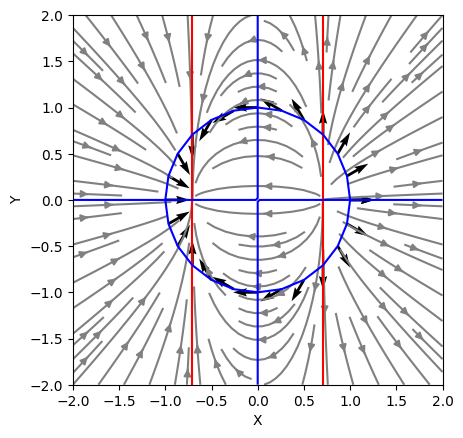

In [10]:
r0=[0,0]  # the coordinates for the centre of the circle
rr= 1  # the radius of the circle
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

ax=plot_flow(ax,ex1,xrange=[-2,2],yrange=[-2,2],nullclines=True)
ax=plot_jordan(ax,ex1,r0=r0, rr=rr, vectors=True,vector_scale=15)

index = winding_number(ex1, r0, rr)
print(f"r0: {r0}, rr: {rr}")
print(f"The index of the Jordan curve is: {index}")

**Try this:** Play around with moving the circle to different locations and with different radius, fill in the table below for different columns r0, rr and the resulting winding number:

| $r_0$      | $rr$  | Winding Number |
|:----------:|:-----:|:--------------:|
| [0, 0]     | 1   |       2         |
| [0, 0]     | 2  |         2       |
| [1, 0]     | 0.5   |      1          |
| [1, 0]     | 2     |        2        |
| [1, 1]    | 0.5   |        0        |



### Example 2
Let's look at the critical point in origin for the linear system:
$$
\begin{array}{rl}
\dot{x}=& y \\
\dot{y}=&\beta x + 2\alpha y
\end{array}
$$

We have the following eigenvalues (check this!):
$$
\lambda_{\pm}=\alpha \pm \sqrt{\alpha^2+\beta}
$$


Cases:
- $\alpha=0 \Rightarrow \lambda_{\pm}=\pm \sqrt{\beta}$
    -  Saddle point if $\beta >0$
    -  Center if $\beta <0$
- $\beta \lt -\alpha^2$: spiral
    - stable spiral if $\alpha <0 $,
    - unstable spiral if $\alpha > 0 $
- $- \alpha^2 < \beta \lt 0$:
    - stable node if $\alpha <0$
    - unstable node if $\alpha >0$
- $\beta > 0$:
    - saddle point (unstable)


Use this to look at the index of the different critical points.

In [11]:
def ex2(t,xy,params=None):
    # alpha > 0
    if params is not None:
        alpha, beta = params
    else:
        alpha=1
        beta=-1.5
    x,y=xy
    dx=y
    dy=beta*x+2*alpha*y
    return [dx,dy]


jacobian at r0:[[0. 1.]
 [1. 2.]]
Eigenvalues: [-0.41421356  2.41421356]
r0: [0, 0], rr: 0.5
alpha: 1, beta: 1
The index of the Jordan curve is: -1.0000000000000002


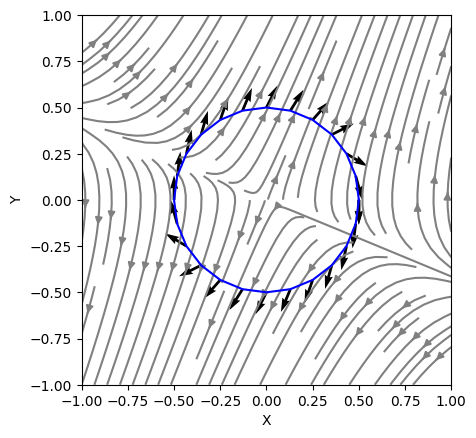

In [24]:
#Change these values to see different behavior
alpha=1
beta=1

params=(alpha,beta)

# Define the Jordan curve.
r0=[0,0]  # the coordinates for the centre of the Jordan curve
rr=  .5   # the radius of the Jordan curve

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

ax=plot_flow(ax,ex2,xrange=[-1,1],yrange=[-1,1],nullclines=False,params=params)
#ax=plot_solution(ax,ex1, y0=[0.1,0], t_end=1, color='green', init_pt=True, linewidth=2.5, params=params)
ax=plot_jordan(ax,ex2,r0=r0, rr=rr, vectors=True,vector_scale=15)
jac=jacobian(ex2, r0,params=params)
eigenvalues=eigenvalues_eigenvectors(jac)
print(f'jacobian at r0:{jac}')
print(f"Eigenvalues: {eigenvalues[0]}")
index = winding_number(ex2, r0, rr,params=params)
print(f"r0: {r0}, rr: {rr}")
print(f'alpha: {alpha}, beta: {beta}')
print(f"The index of the Jordan curve is: {index}")

**Try this:** Play around with moving the circle to different locations and with different radius, make a table on paper with columns r0, rr and the resulting winding number:

| $\alpha$      | $\beta$  | Type of equilibrium point| Winding Number  |  
|:----------:|:-----:|:--------------:|:--------------:|
| 0     | 1  |        saddle  |-1
| 0     | -1   |    center            |1
| 2     | -5    | unstable spiral  |1
| -2    | -5  |   stable spiral          |1
| -2    | -1  |    stable node          |1
| 2    | -1  |      unstable node        |1
| 2    | 1  |     saddle           |-1
| -2    | 1  |       saddle         |-1

**Special attention:** Look specially at the cases where $\alpha=0$ and $\beta <0$.  

## The example from last time
The problem we used when introducing _flow_ last time:
$$
\begin{array}{rl}
 x'(t) = & y, \\[0.5pt]
 y'(t) = & x(1-x^2)-y.
\end{array}
$$


### Linear analysis (revisited)
Isocline: $\dot{x}$ is zero when $y=0$.

Isocline:  $\dot{y}$ is zero when $y=x(1-x^2)=x(1-x)(1+x)$.  

Hence, equilibrium points at $(x,y)=(0,0)$ (saddle point), $(x,y)=(1,0)$ and $(x,y)=(-1,0)$ (both stable spirals).

Defining the function:

In [25]:
def rhs(t,xy,params=None):
    x,y=xy
    dx=y
    dy=x*(1-x**2)-y
    return [dx,dy]

r0: [0, 0], rr: 1.5
The index of the Jordan curve is: 1.0


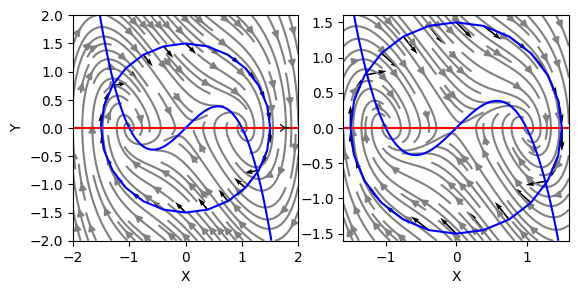

In [35]:
r0=[0,0]  # the coordinates for the centre of the circle
rr= 1.5   # the radius of the circle

xrange=[-2,2]
yrange=[-2,2]
fig, ax = plt.subplots(1, 2)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_aspect('equal')

ax[0]=plot_flow(ax[0],rhs,xrange=xrange,yrange=yrange,nullclines=True)

# Lets plot a Jordan curve, a circle.
ax[0]=plot_jordan(ax[0],rhs,r0=r0, rr=rr, vectors=True,vector_scale=15)

# A zoomed image
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_aspect('equal')
xrange=[r0[0]-rr-0.1,r0[0]+rr+0.1]
yrange=[r0[1]-rr-0.1,r0[1]+rr+0.1]
ax[1]=plot_flow(ax[1],rhs,xrange=xrange,yrange=yrange,nullclines=True)

# Lets plot a Jordan curve, a circle.
ax[1]=plot_jordan(ax[1],rhs,r0=r0, rr=rr, vectors=True,vector_scale=10)

ax[1].set_xlim(xrange[0],xrange[1])
ax[1].set_ylim(yrange[0],yrange[1])

index = winding_number(rhs, r0, rr)
print(f"r0: {r0}, rr: {rr}")
print(f"The index of the Jordan curve is: {index}")



**Try this:** Play around with moving the circle to different locations and with different radius, make a table on paper with columns r0, rr and the resulting winding number:

| $r_0$      | $rr$  | Winding Number |
|:----------:|:-----:|:--------------:|
| [0, 0]     | 0.5   |    -1          |
| [0, 0]     | 1.5   |       1        |
| [0, 0]     | 3     |    1=1-1+1     |
| [1, 0]     | 0.5   |      1         |
| [1, 0]     | 1.5   |    0=1-1       |
| [1, 0]     | 3     |    1=1-1+1     |
| [-1, 0]    | 0.5   |      1         |
| [-1, 0]    | 1.5   |    0=1-1       |
| [-1, 0]    | 3     |    1=1-1+1     |

Do you see a pattern?

## The pendulum
Let's do the same with the pendulum

r0: [3.141592653589793, 0], rr: 1
The index of the Jordan curve is: -1.0


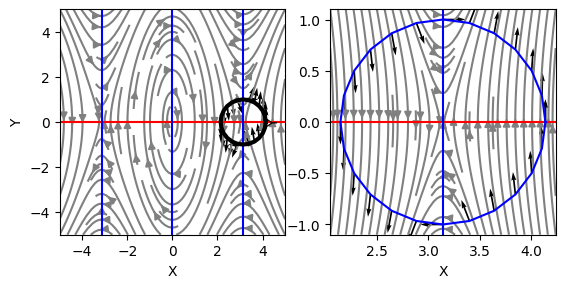

In [27]:
def pendulum(t,x,params=None):
    if params is None:
        params=[1,9.8]
    l,g = params
    return np.array([x[1],-g/l*np.sin(x[0])])


l=1
g=9.8
params=[l,g]

r0=[np.pi,0]  # the coordinates for the centre of the circle
rr=  1  # the radius of the circle

fig, ax = plt.subplots(1, 2)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_aspect('equal')

ax[0]=plot_flow(ax[0],pendulum,xrange=[-5,5],yrange=[-5,5],nullclines=True,params=params)
ax[0]=plot_jordan(ax[0],pendulum,r0=r0,rr=rr, vectors=True,linewidth=3,color='black',vector_scale=15)

# A zoomed image
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_aspect('equal')
xrange=[r0[0]-rr-0.1,r0[0]+rr+0.1]
yrange=[r0[1]-rr-0.1,r0[1]+rr+0.1]
ax[1]=plot_flow(ax[1],pendulum,xrange=xrange,yrange=yrange,nullclines=True,params=params)

# Lets plot a Jordan curve, a circle.
ax[1]=plot_jordan(ax[1],pendulum,r0=r0, rr=rr, vectors=True,vector_scale=10)

ax[1].set_xlim(xrange[0],xrange[1])
ax[1].set_ylim(yrange[0],yrange[1])

index = winding_number(pendulum, r0, rr,params=params)
print(f"r0: {r0}, rr: {rr}")
print(f"The index of the Jordan curve is: {index}")

**Try this:** Play around with moving the circle to different locations and with different radius, make a table on paper with columns r0, rr and the resulting winding number:

| $r_0$      | $rr$  | Winding Number |
|:----------:|:-----:|:--------------:|
| [$\pi$, 0]     | 1   |                |
| [$\pi$, 0]    | $\frac{3\pi}{2}$   |                |
| [$\frac{\pi}{2}$, 0]    | $\pi$    |                |
| [0, 0]     | 0.5   |                |
| [0, 0]     | $0.99\pi$   |                |
| [0, 0]     | $1.01\pi$     |                |
| [0.1, 0]    | $1.01\pi$   |                |
| [1, 1]    | 1  |                |


Do you see a pattern?